# Harmonic experiment

In [9]:
%pip install --upgrade plotly numpy nbformat kaleido pandas

Note: you may need to restart the kernel to use updated packages.


In [25]:
import glob
import os
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
from pathlib import Path
from IPython.display import display, Image

pio.kaleido.scope.mathjax = None

results_dir = Path("results").resolve()
print("Results directory:", results_dir)

Results directory: /home/yohan/Work/fuzzy-pytorch/experiments/harmonics/results


/tmp/ipykernel_2961505/1457042936.py:11: DeprecationWarning:


Use of plotly.io.kaleido.scope.mathjax is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.mathjax instead.




In [11]:
def extract_hex(line):
    return float.fromhex(line.split("(")[1].split(")")[0])


def extract_values_default(file):
    with open(file, "r") as f:
        values = map(extract_hex, f.read().splitlines())
    return np.fromiter(values, dtype=np.float64)


def extract_cadna_line(line):
    # RESULT:  +5.18738175e+00 -- +5.18737698e+00 -- +5.18738509e+00
    return re.findall(r"\+\d+\.\d+e[+-]\d+", line)


def extract_values_cadna(file):
    with open(file, "r") as f:
        values = map(extract_cadna_line, f.read().splitlines())
        # flatten list of lists
        values = [item for sublist in values for item in sublist]
    return np.fromiter(values, dtype=np.float64)


def extract_values(file, tool):
    if "cadna" in tool:
        return extract_values_cadna(file)
    else:
        return extract_values_default(file)


def load_data(directory):
    files = glob.glob(os.path.join(directory, "*.txt"))
    df = pd.DataFrame(columns=["tool", "mode", "iterations"])
    for file in files:
        tool, mode, iterations = os.path.splitext(os.path.basename(file))[0].split("-")
        values = extract_values(file, tool)
        mean = np.mean(values)
        std = np.std(values)
        _df = pd.DataFrame(
            {
                "tool": [tool],
                "mode": [mode],
                "iterations": [int(iterations)],
                "mean": [mean],
                "std": [std],
            }
        )
        df = pd.concat([df, _df])
    return df

In [19]:
df = load_data(results_dir)
df.to_csv("harmonic-numerics.csv")
df

,tool,mode,iterations,mean,std
0,prism_sr,perf,4132,8.903862,0.000010
0,prism_sr,perf,16681,10.299320,0.000048
0,prism_sr,dbg,42292,11.229554,0.000063
0,verrou_cestac,dbg,2056,8.205997,0.000009
0,cadna,dbg,33516,10.996839,0.000318
...,...,...,...,...,...
0,prism_sr,dbg,1149,7.624297,0.000008
0,baseline_float,dbg,977009,14.335432,0.000000
0,sr,dbg,59948,11.578574,0.000046
0,sr,dbg,2477076,15.299238,0.000529


In [15]:
marker_map = {
    "baseline_double": "star",
    "baseline_float": "hexagram",
    "verrou_cestac": "x",
    "cadna": "x",
    "verrou_sr": "triangle-up",
    "prism_sr": "triangle-up",
    "prism_ud": "diamond",
    "sr": "triangle-up",
    "verificarlo": "triangle-up",
}

legend_map = {
    "prism_sr": "PRISM SR",
    "baseline_double": "IEEE binary64",
    "cadna": "CESTAC",
    "verificarlo": "MCA RR",
    "baseline_float": "IEEE binary32",
    "verrou_sr": "Verrou SR",
    "sr": "SR",
    "prism_ud": "PRISM UD",
    "verrou_cestac": "Verrou CESTAC",
}

legendgroup_map = {
    "prism_sr": "PRISM",
    "baseline_double": "IEEE",
    "cadna": "CADNA",
    "verificarlo": "MCA",
    "baseline_float": "IEEE",
    "verrou_sr": "VERROU",
    "sr": "SR",
    "prism_ud": "PRISM",
    "verrou_cestac": "VERROU",
}

colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

color_map = {
    "PRISM": colors_map["PRISM"],
    "VERROU": colors_map["Verrou"],
    "CADNA": colors_map["CESTAC"],
    "IEEE": colors_map["IEEE"],
    "SR": colors_map["FM SR"],
    "MCA": colors_map["MCA RR"],
}

## Mean 

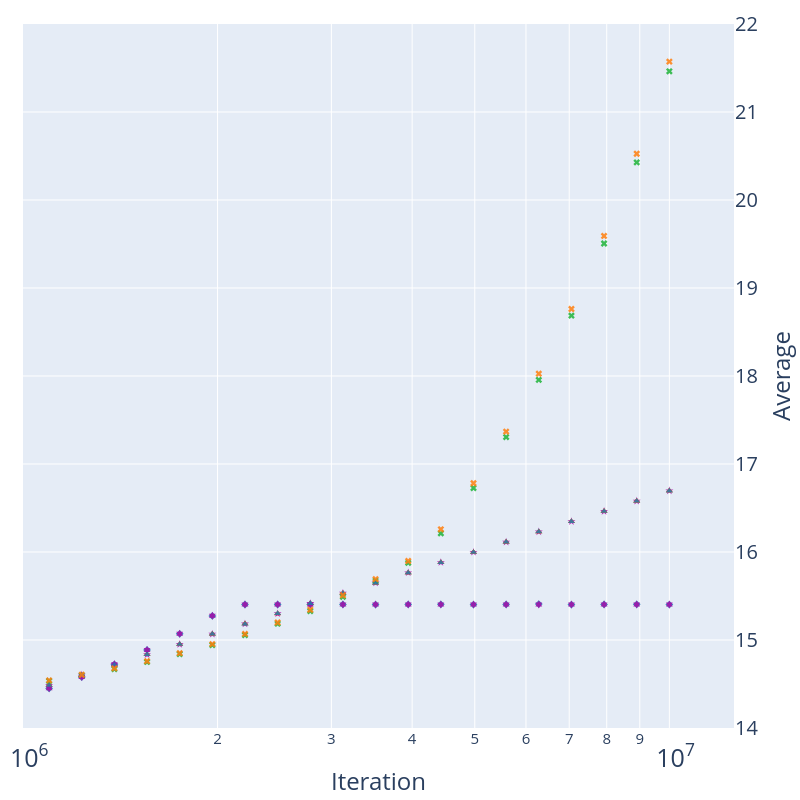

In [31]:
df = pd.read_csv("harmonic-numerics.csv")
df.sort_values(by=["iterations"], inplace=True)
df_perf = df[df["mode"] == "perf"]
fig = px.scatter(
    df_perf,
    x="iterations",
    y="mean",
    color="tool",
    #            facet_col="mode",
    # markers=True,
    log_x=True,
    # error_y="std",
)


for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig.update_traces(marker=dict(size=6))
fig.update_traces(marker=dict(opacity=0.85))

ytitle = "Average"
xtitle = "Iteration"
fig.update_yaxes(title=ytitle)
fig.update_xaxes(type="log", exponentformat="power", title=xtitle)

fig.update_xaxes(range=[6, 7.1])
fig.update_yaxes(range=[14, 22], side="right")

fig.update_layout(legend_title_text="Method")
fig.update_layout(font=dict(size=20))

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        itemwidth=30,  # Increase this value to increase space between labels
        itemsizing="constant",
        font=dict(size=20),  # Reduce font size of legend
    )
)

# do not show legend for mean
fig.update_layout(showlegend=False)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=10))
fig.update_layout(
    xaxis=dict(title=dict(standoff=0))  # Adjust this value to move the x-axis title up
)
display(Image(fig.to_image(width=800, height=800)))
fig.show()

## Standard deviation

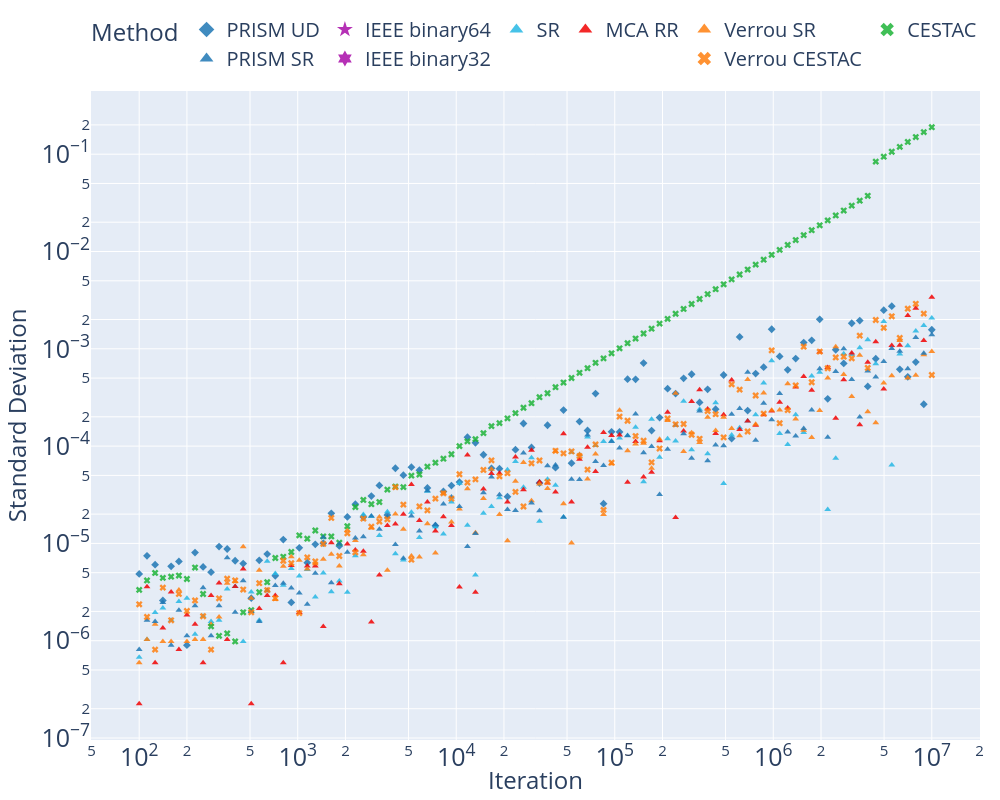

In [29]:
df = pd.read_csv("harmonic-numerics.csv")
df.sort_values(by=["iterations"], inplace=True)
df_perf = df[df["mode"] == "perf"]
fig = px.scatter(
    df_perf,
    x="iterations",
    y="std",
    color="tool",
    #           facet_col="mode",
    log_x=True,
    log_y=True,
)


for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig.update_traces(marker=dict(size=6))
fig.update_traces(marker=dict(opacity=0.85))

ytitle = "Standard Deviation"
xtitle = "Iteration"
fig.update_yaxes(type="log", exponentformat="power")
fig.update_yaxes(title=ytitle)
fig.update_xaxes(type="log", exponentformat="power", title=xtitle)

# hide FLOAT and DOUBLE
fig.update_traces(visible=True, selector=dict(name="IEEE binary32"))
fig.update_traces(visible=True, selector=dict(name="IEEE binary64"))

fig.update_layout(legend_title_text="Method")
fig.update_layout(font=dict(size=20))

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        itemwidth=30,  # Increase this value to increase space between labels
        itemsizing="constant",
        font=dict(size=20),  # Reduce font size of legend
    )
)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=10))
fig.update_layout(
    xaxis=dict(title=dict(standoff=0))  # Adjust this value to move the x-axis title up
)

display(Image(fig.to_image(width=1000, height=800)))
fig.show()